In [13]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from RateTraining import *

In [15]:
npar, tpar, trpar, cpar, rpar = create_default_params_rate()
tpar['stim_off'] = 50
npar['net_size'] = 500

In [16]:
def gen_rand_stim(n_par, time_par):
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)
    
    stim = np.zeros((N, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        stim[row][int(time_par['stim_on']/dt):int(time_par['stim_off']/dt)] = rstim
    return stim

In [17]:
def gen_sawtooth_stim(npar, time_par):
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)

    stim = np.zeros((N, timesteps))
    for row in range(N):
        pass    

In [18]:
def gen_sine_targets(n_par, time_par): 
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)
    
    targets = np.zeros((N, timesteps))
    for i in range(N):
        A = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, time_par['total_time'], timesteps)
        targets[i] = A * np.sin(2 * np.pi * (x - t0)/t1)
    return targets

In [19]:
stim = gen_rand_stim(npar, tpar)

In [20]:
targs = gen_sine_targets(npar, tpar)

In [21]:
np.shape(targs)

(500, 2000)

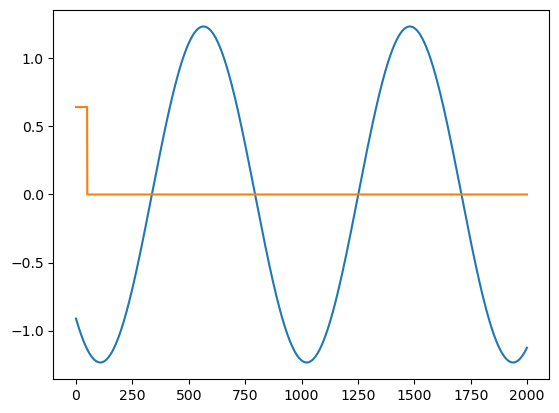

In [22]:
plt.plot(targs[1])
plt.plot(stim[1])

In [23]:
net = RateTraining(npar, tpar, trpar, cpar, rpar)
net.nloop = 20

In [24]:
x, Hx, errs, rel_errs = net.train_rate(stim, targs)

training trial 0


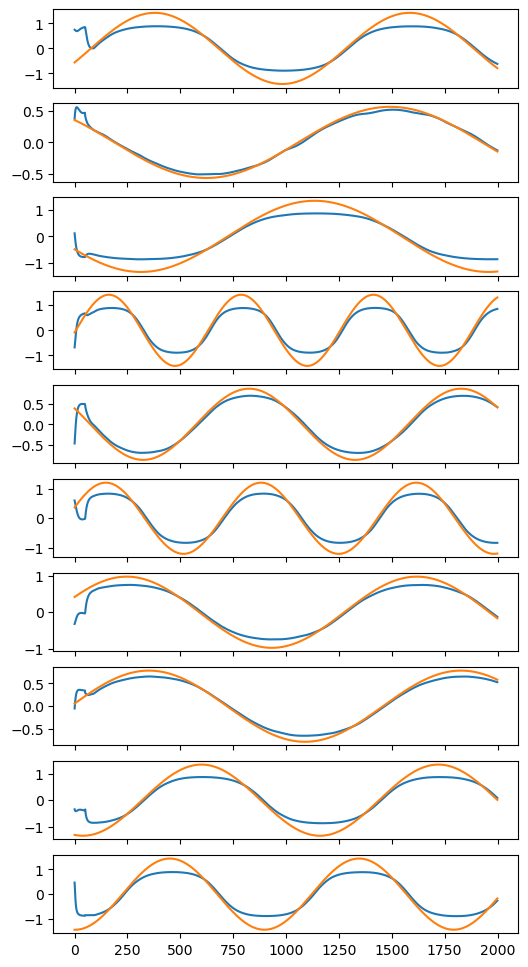

In [ ]:
n_plot = 10
nloop = trpar['training_loops']
timesteps = int(tpar['total_time']/tpar['dt'])
btp = 19

fig, axs = plt.subplots(n_plot + 1, 1, figsize = (12, 12), sharex = True)
for i in range(n_plot):
    # axs[i].plot(Hxt[i, 0:timesteps])
    # axs[i].plot(aux_targs[i, 0:timesteps])
    axs[i].plot(Hx[i, (btp)*timesteps:(btp + 1)*timesteps])
    axs[i].plot(targs[i, (btp)*timesteps:(btp + 1)*timesteps])

axs[0].set_title("Sample task-generating internal behavior")

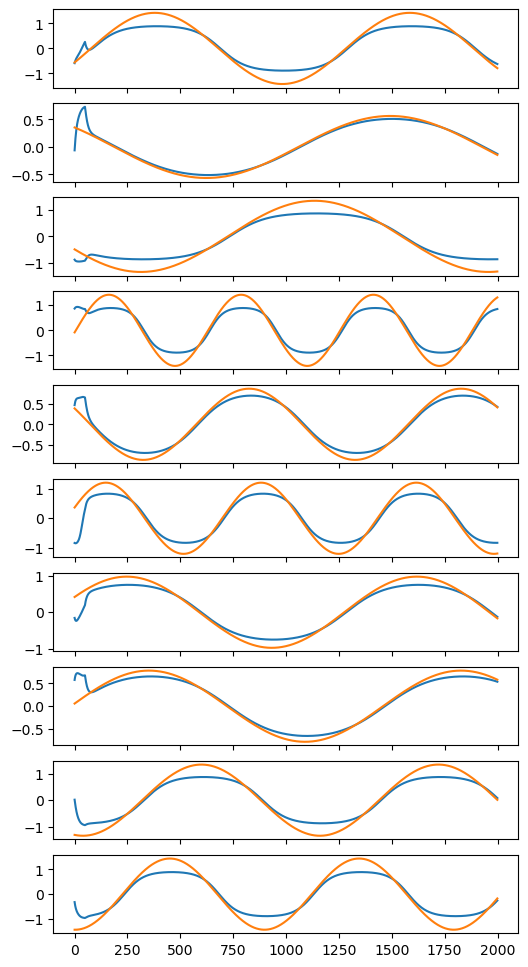

In [ ]:
n_plot = 10
nloop = net.nloop
timesteps = int(net.run_time / net.dt)

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hx[i, (nloop - 1)*timesteps:nloop*timesteps])
    axs[i].plot(targs[i])
    #axs[i].plot(stim[i])

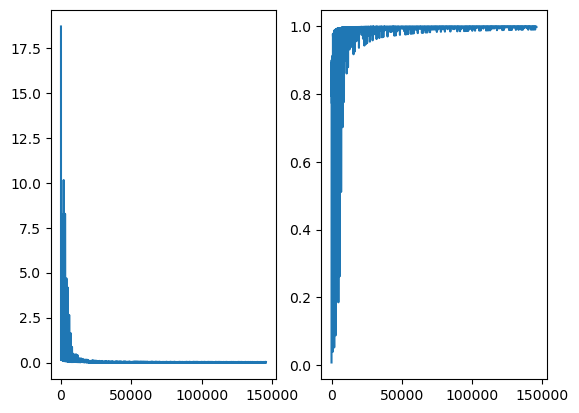

In [53]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(errs)
axs[1].plot(rel_errs)

In [54]:
xr, hxr = net.run_rate(stim)

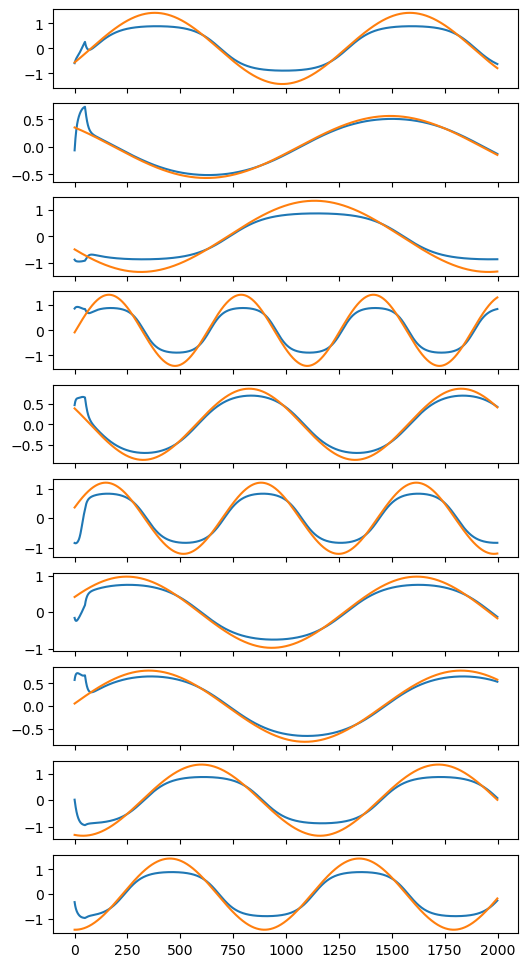

In [55]:
n_plot = 10
nloop = net.nloop
timesteps = int(net.run_time / net.dt)

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(hxr[i])
    axs[i].plot(targs[i])
    #axs[i].plot(stim[i])

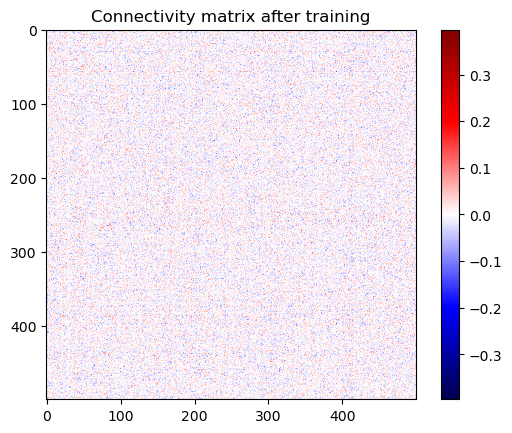

In [56]:
m = max(-1*np.min(net.W_trained), np.max(net.W_trained))

plt.imshow(net.W_trained, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Connectivity matrix after training")
plt.colorbar()

C:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Clustered connectivity matrix after training')

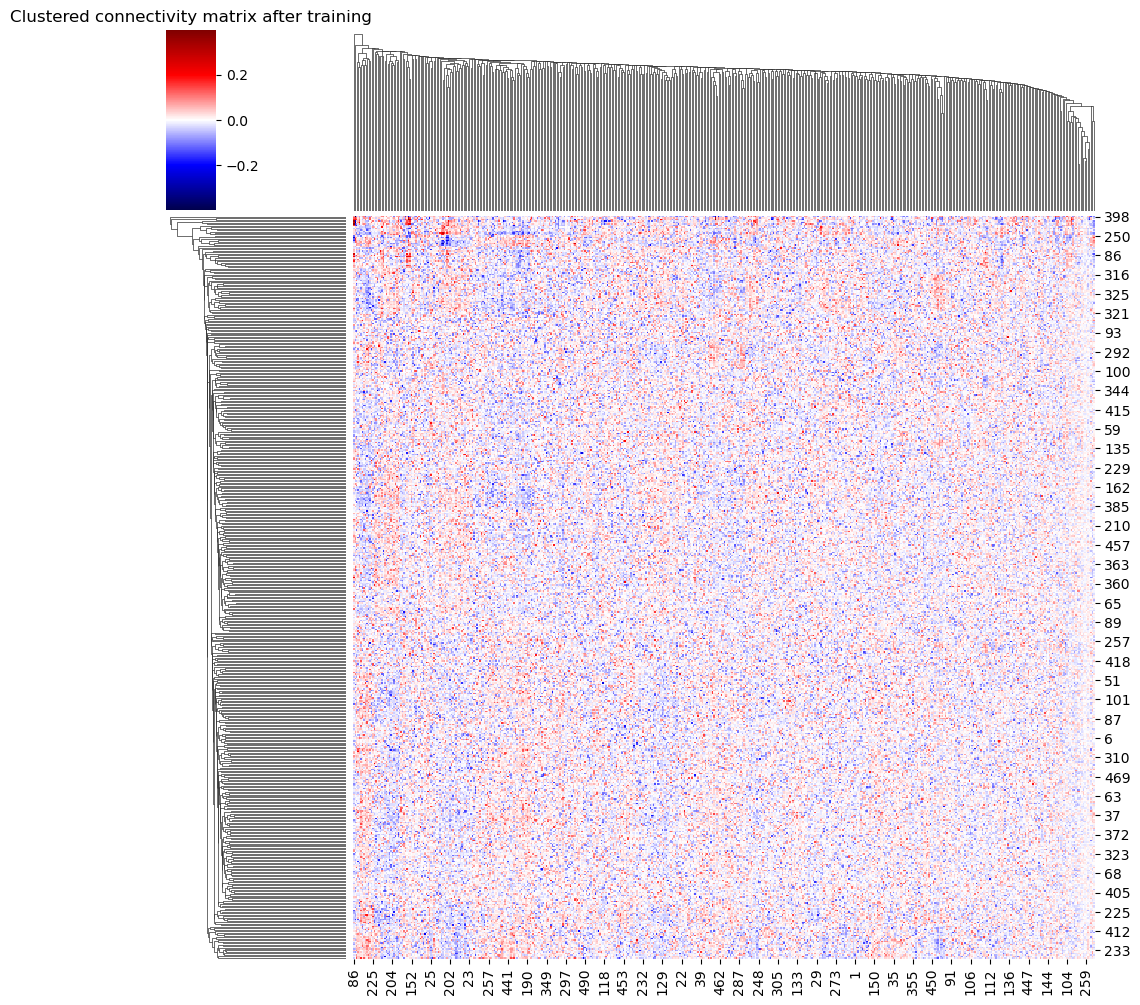

In [57]:
sns.clustermap(net.W_trained, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Clustered connectivity matrix after training")